In [72]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats


import SessionTools.two_photon as st2p

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EPG_jGCaMP7b_VK05')
sess_df = pd.read_csv(basedir / 'sessions.csv')
sess_df['fly_id'] = [row['date']+'_'+row['fly'] for _, row in sess_df.iterrows()]
figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/cosyne_2024/poster/pharmacology/')
figfolder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]

In [95]:
stats_df = {'fly_id': [],
           'cl': [],
           'drug': [],
            'corr': [],
           'offset_var':[]}


for _,row in sess_df.iterrows():
    if row['usable']==1:
        outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        
        dff = pp.timeseries['rois_z'][0,:,:]-1
        
        heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
        
        x_f,y_f = st2p.utilities.pol2cart(dff ,np.linspace(-np.pi,np.pi,num=dff.shape[0])[:,np.newaxis])
        rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
       
        _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
        
        corr = ast.stats.circcorrcoef(heading,phi)
        
        stats_df['fly_id'].append(row['fly_id'])
        stats_df['cl'].append(row['closed_loop'])
        stats_df['drug'].append(row['drug'])
        stats_df['corr'].append(corr)
        
        
        stats_df['offset_var'].append(sp.stats.circvar(offset))
stats_df = pd.DataFrame.from_dict(stats_df)

In [96]:
fly_ids = stats_df['fly_id'].unique()

drug_ids = np.zeros((len(fly_ids),))
for i, fly in enumerate(fly_ids):
    drug_ids[i] = stats_df['drug'].loc[stats_df['fly_id']==fly].iloc[0]

5.0 0.0029526029526029526
29.0 0.331387096247615
10.0 0.011106540518305223
45.0 0.4234471410941999
66.0 0.0024681201151789383


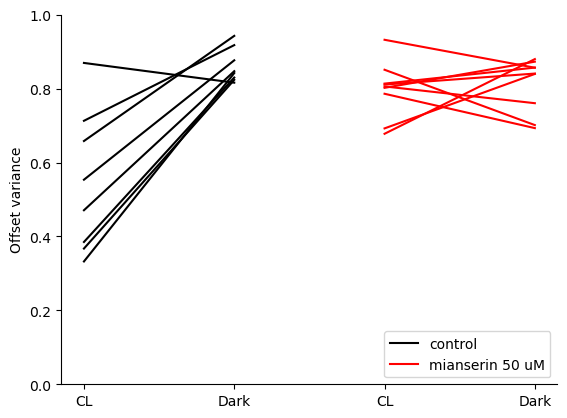

In [97]:
fly_avgs = np.zeros((len(fly_ids),2))
for r, fly in enumerate(fly_ids):
    
    mask = (stats_df['fly_id']==fly)*(stats_df['cl']==1)
    cl = stats_df['offset_var'].loc[mask].mean()
    fly_avgs[r,0]=cl
    
    mask = (stats_df['fly_id']==fly)*(stats_df['cl']==0)
    dark = stats_df['offset_var'].loc[mask].mean()
    fly_avgs[r,1] = dark
    

fig,ax = plt.subplots()
c_h = ax.plot([0,1],fly_avgs[drug_ids==0,:].T, color='black', label='Control')


d_h = ax.plot([2,3],fly_avgs[drug_ids==1,:].T, color='red', label='Mianserin 50 uM')

t,p = sp.stats.mannwhitneyu(fly_avgs[drug_ids==0,0], fly_avgs[drug_ids==0,1])
print(t,p)

t,p = sp.stats.mannwhitneyu(fly_avgs[drug_ids==1,0], fly_avgs[drug_ids==1,1])
print(t,p)

t,p = sp.stats.mannwhitneyu(fly_avgs[drug_ids==0,0], fly_avgs[drug_ids==1,0])
print(t,p)

t,p = sp.stats.mannwhitneyu(fly_avgs[drug_ids==0,1], fly_avgs[drug_ids==1,1])
print(t,p)

diff = fly_avgs[:,1]-fly_avgs[:,0]
t,p = sp.stats.mannwhitneyu(diff[drug_ids==0], diff[drug_ids==1])
print(t,p)

ax.set_ylim([0,1])
ax.set_xticks([0, 1, 2, 3], labels=['CL', 'Dark', 'CL', 'Dark'])
ax.set_ylabel('Offset variance')
ax.legend([c_h[0],d_h[0]], ['control', 'mianserin 50 uM'], loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(figfolder / 'mianserin_50microM_summary.pdf', format='pdf')

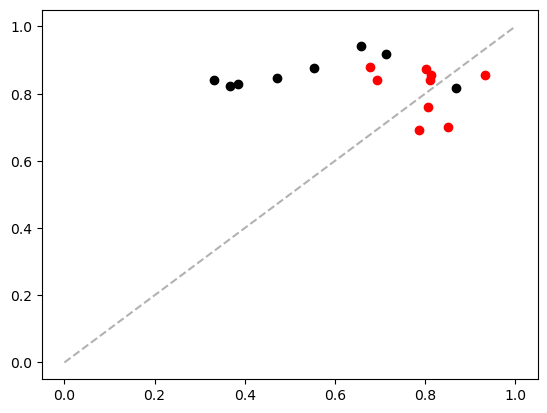

In [78]:
fig, ax = plt.subplots()
ax.scatter(fly_avgs[drug_ids==0,0], fly_avgs[drug_ids==0,1], c='black')
ax.scatter(fly_avgs[drug_ids==1,0], fly_avgs[drug_ids==1,1], c='red')
ax.plot([0,1],[0,1],'k--', alpha=.3, zorder=-1)

3.5232075182972893 0.003375888517446638
2.099563066685332 0.05198393225343568
2.144270537187633 0.04880171278069551
-0.021384925529521797 0.9832204778441256
-2.1045605278467936 0.0526018011239095


Text(0, 0.5, 'Phase-Heading Corr')

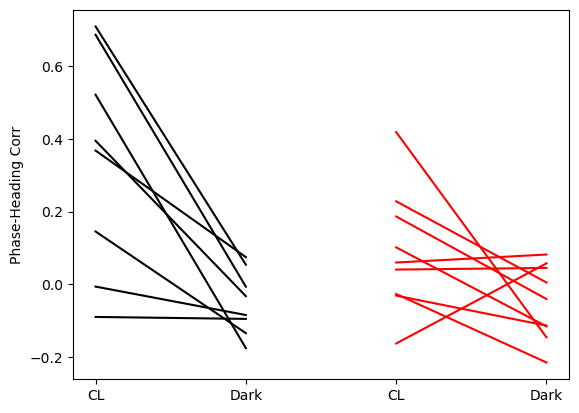

In [79]:
fly_avgs = np.zeros((len(fly_ids),2))
for r, fly in enumerate(fly_ids):
    
    mask = (stats_df['fly_id']==fly)*(stats_df['cl']==1)
    cl = stats_df['corr'].loc[mask].mean()
    fly_avgs[r,0]=cl
    
    mask = (stats_df['fly_id']==fly)*(stats_df['cl']==0)
    dark = stats_df['corr'].loc[mask].mean()
    fly_avgs[r,1] = dark
    
fly_avgs = np.arctanh(fly_avgs)

fig,ax = plt.subplots()
c_h = ax.plot([0,1],fly_avgs[drug_ids==0,:].T, color='black', label='Control')


d_h = ax.plot([2,3],fly_avgs[drug_ids==1,:].T, color='red', label='Mianserin 50 uM')

t,p = sp.stats.ttest_ind(fly_avgs[drug_ids==0,0], fly_avgs[drug_ids==0,1])
print(t,p)

t,p = sp.stats.ttest_ind(fly_avgs[drug_ids==1,0], fly_avgs[drug_ids==1,1])
print(t,p)

t,p = sp.stats.ttest_ind(fly_avgs[drug_ids==0,0], fly_avgs[drug_ids==1,0])
print(t,p)

t,p = sp.stats.ttest_ind(fly_avgs[drug_ids==0,1], fly_avgs[drug_ids==1,1])
print(t,p)

diff = fly_avgs[:,1]-fly_avgs[:,0]
t,p = sp.stats.ttest_ind(diff[drug_ids==0], diff[drug_ids==1])
print(t,p)

# ax.set_ylim([0,1])
ax.set_xticks([0, 1, 2, 3], labels=['CL', 'Dark', 'CL', 'Dark'])
ax.set_ylabel('Phase-Heading Corr')
# ax.legend([c_h[0],d_h[0]], ['control', 'mianserin 50 uM'])

In [104]:
def get_ts(pp, coef = 0):
    y_epg = pp.timeseries['rois_z']
    heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
    bar_vis_mask = np.abs(heading)>1.5
   
    y_epg_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y_epg-1, 2, axis=-1),.7,axis=1, mode='wrap')
    
    
    n_rois = y_epg.shape[1]
    x_f,y_f = st2p.utilities.pol2cart(y_epg_sm[0,:,:] ,np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
    rho_epg, phi_epg = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))


    _,offset_epg = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_epg-heading))

    
    return {'heading': heading,
            'bar_vis_mask': bar_vis_mask,
            'y_epg': y_epg,
            'y_epg_sm': y_epg_sm,
            'rho_epg': rho_epg,
            'phi_epg': phi_epg,
            'offset_epg': offset_epg}


def align_to_heading(ts):
    heading_bins = np.linspace(-np.pi, np.pi, num=17)
    heading_dig = np.digitize(ts['heading'], heading_bins)-1

    y_h_aligned = np.zeros_like(ts['y_epg_sm'])
    for ind in range(ts['heading'].shape[0]):
        y_h_aligned[0,:,ind] = np.roll(ts['y_epg_sm'][0,:,ind], -heading_dig[ind])
       
        
    y_h_aligned_z = np.zeros((0,16,16))
    for b in range(16):
        mask = heading_dig==b
        y_h_aligned_z[:,:,b] = y_h_aligned[:,:,mask].mean(axis=-1)
    
    
    return heading_bins, y_h_aligned, y_h_aligned_z

/tmp/ipykernel_367519/3772669617.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax=plt.subplots(1,2, figsize=[9,3])


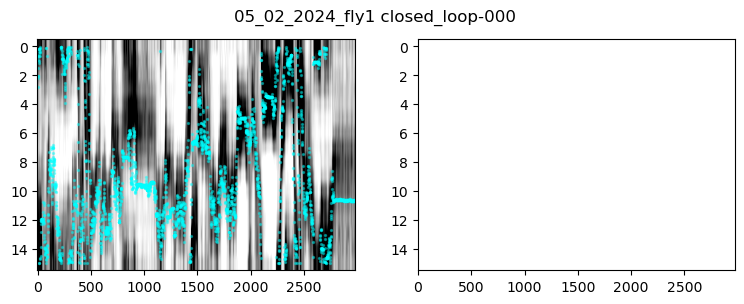

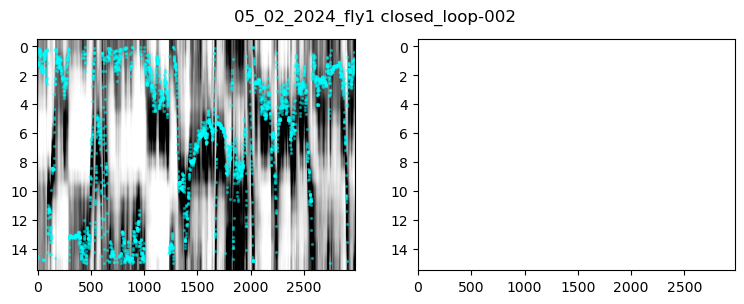

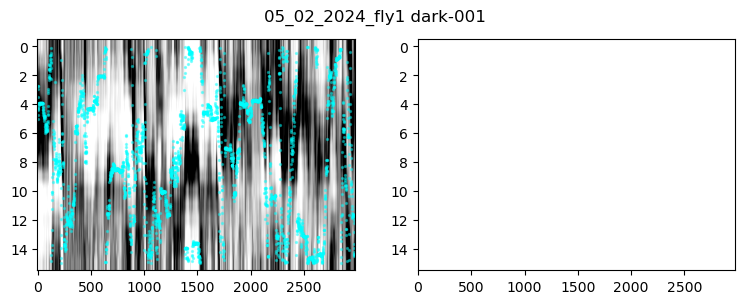

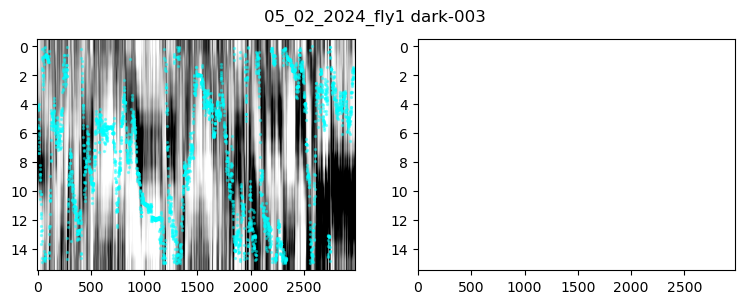

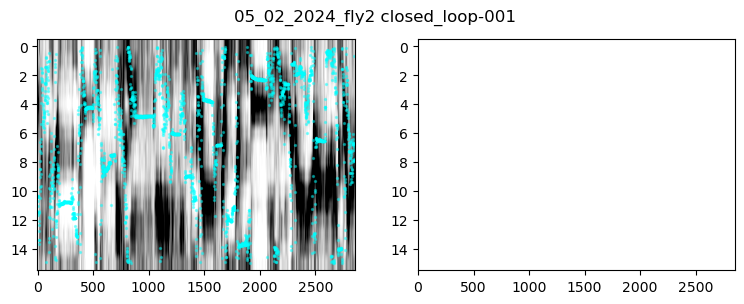

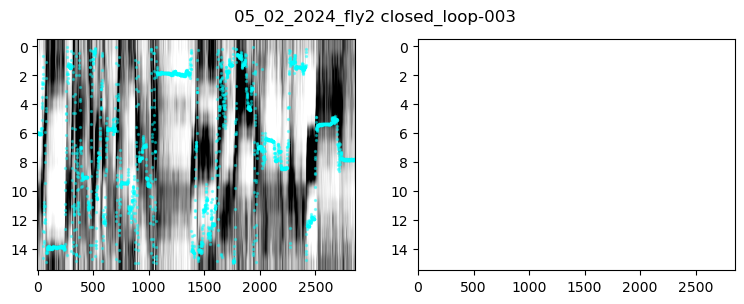

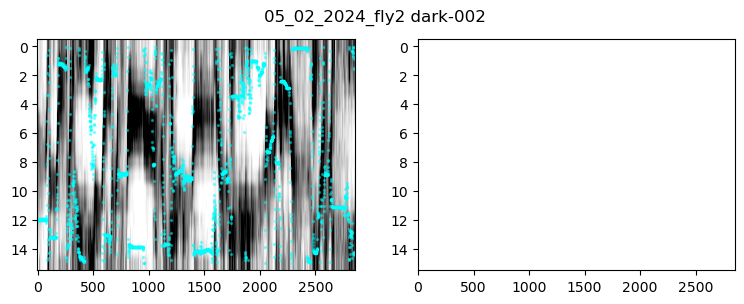

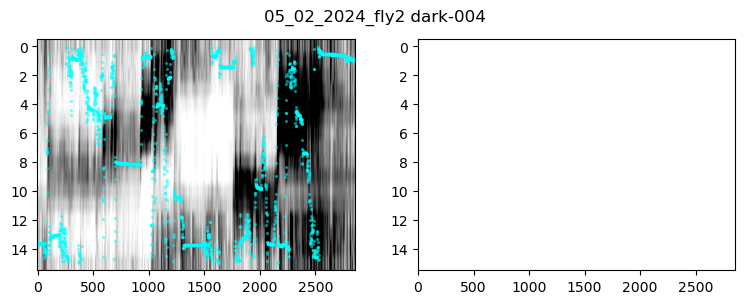

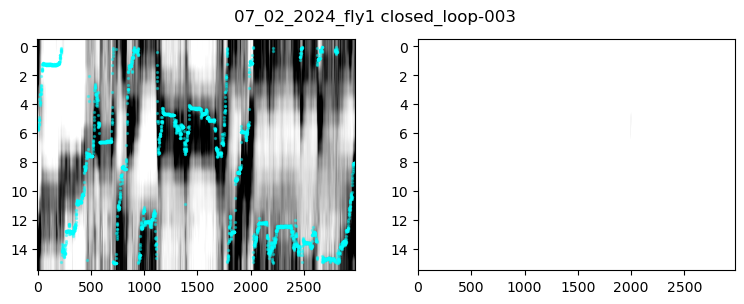

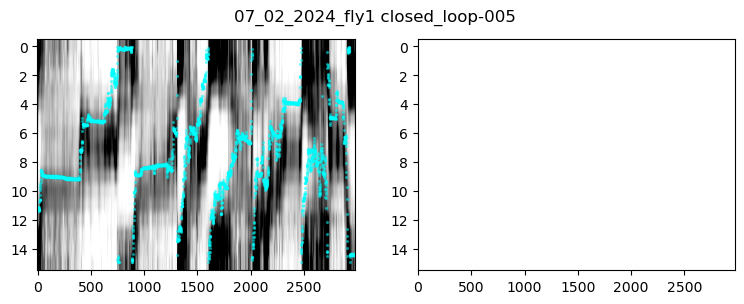

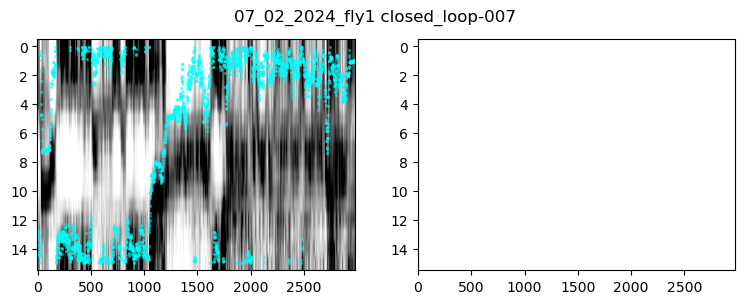

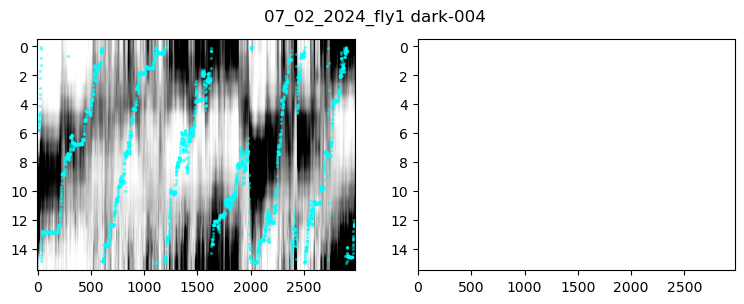

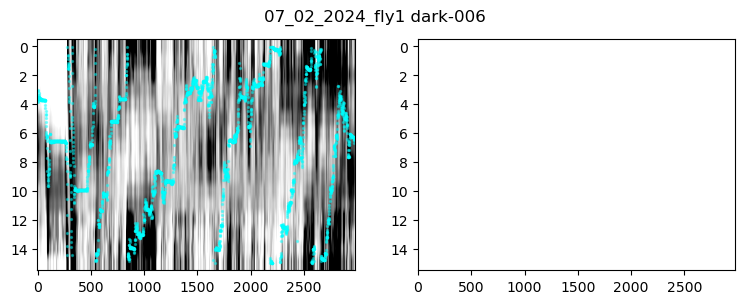

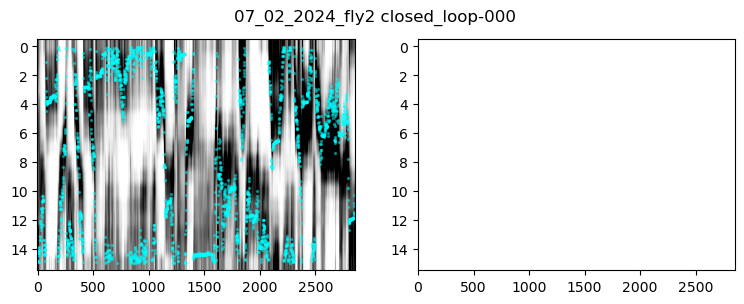

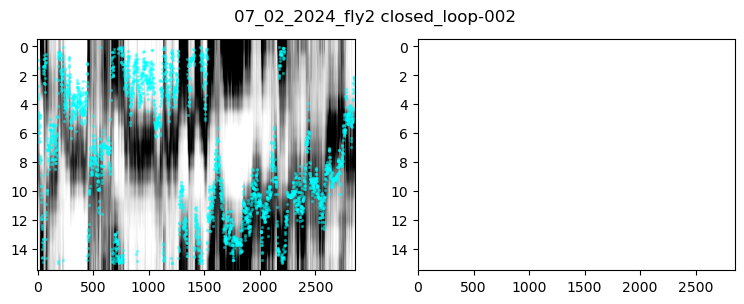

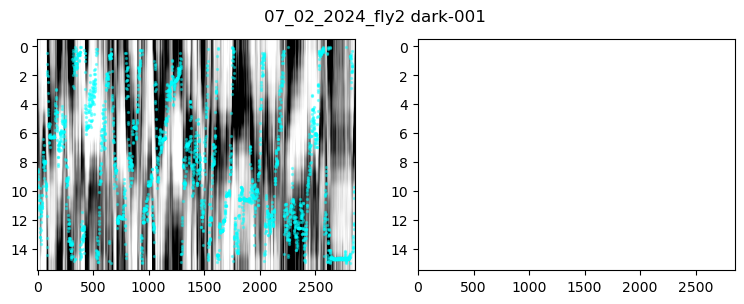

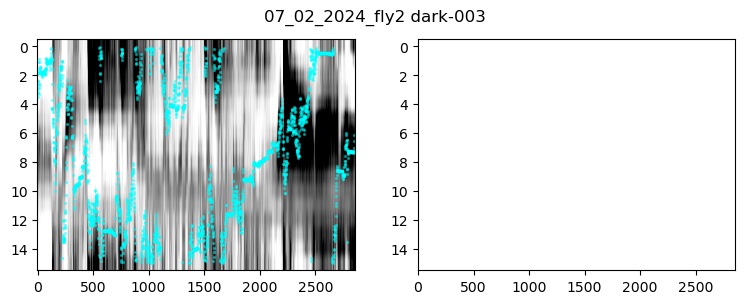

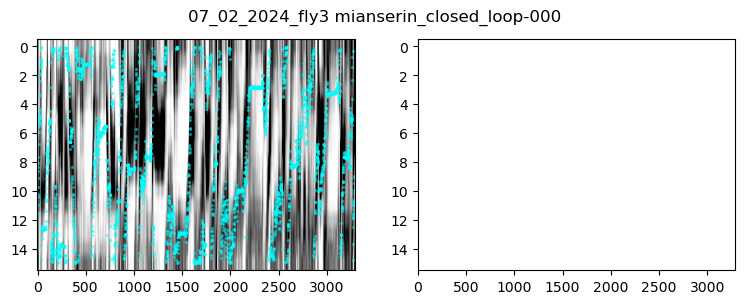

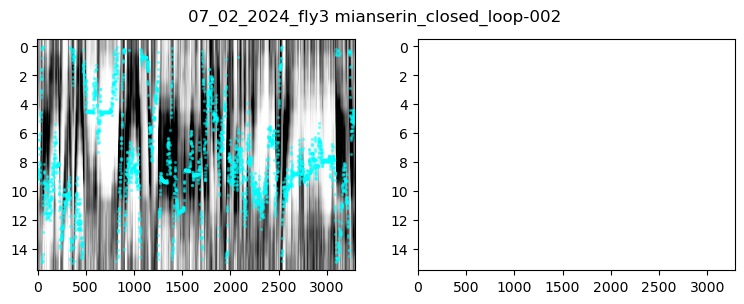

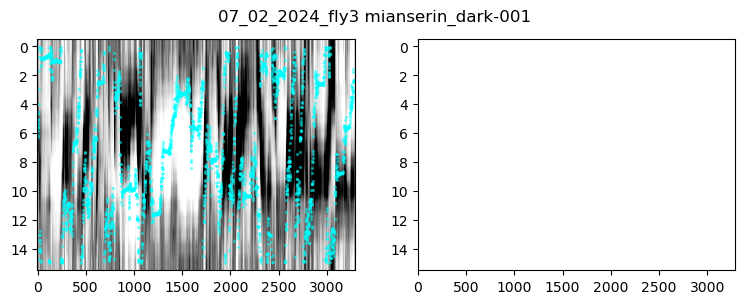

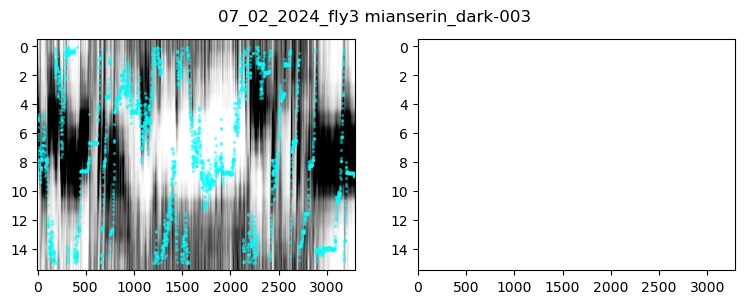

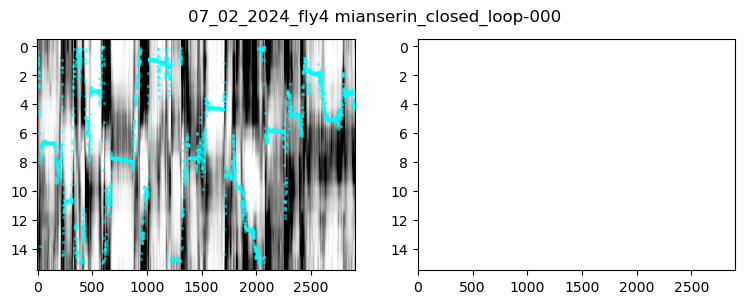

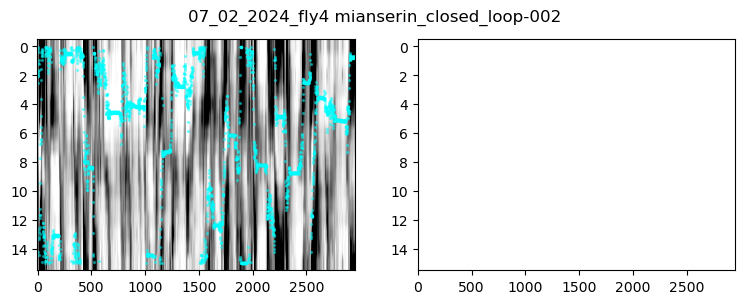

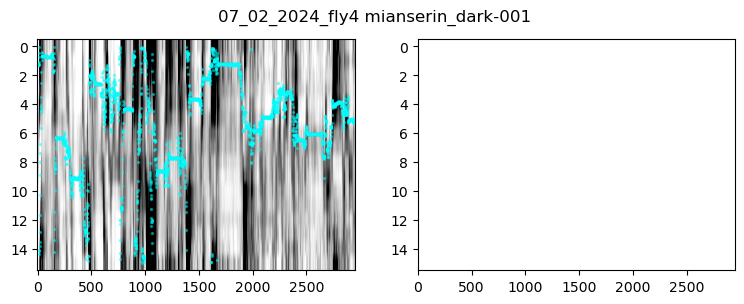

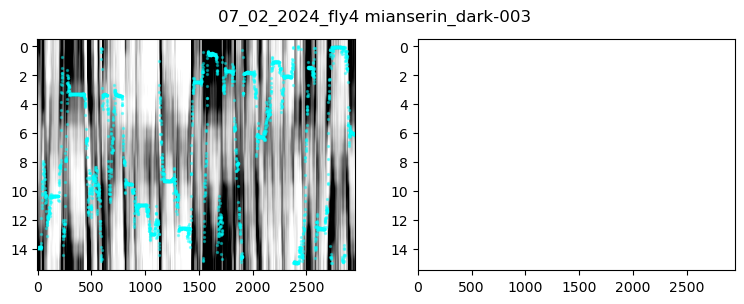

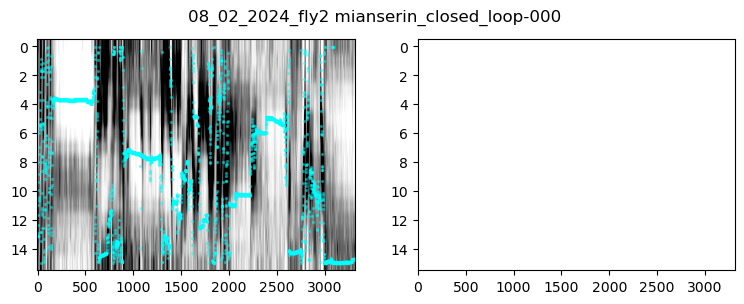

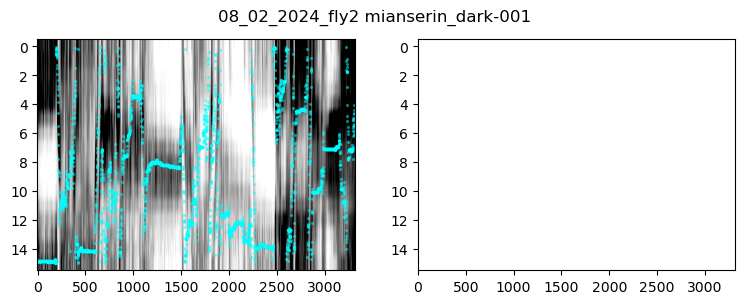

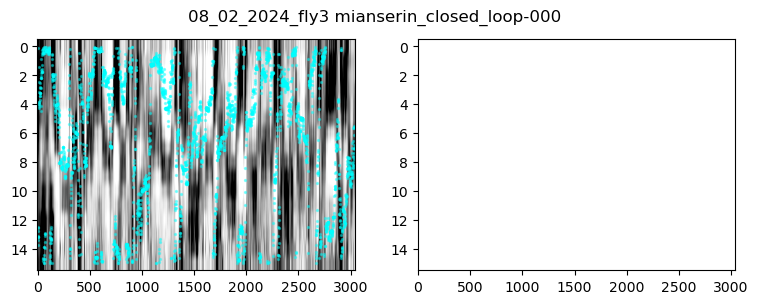

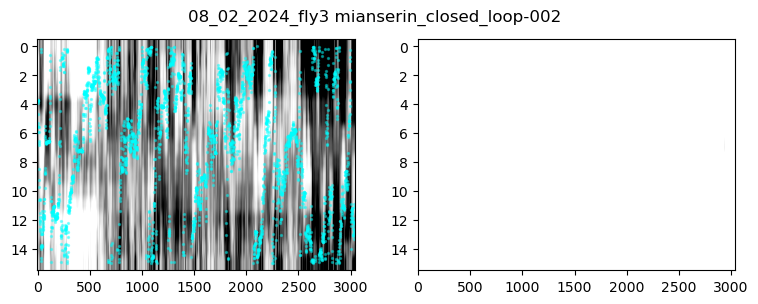

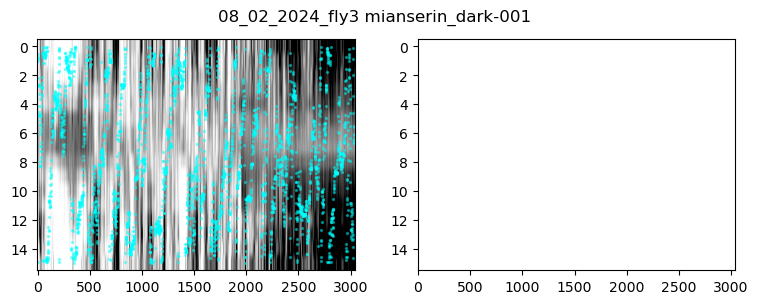

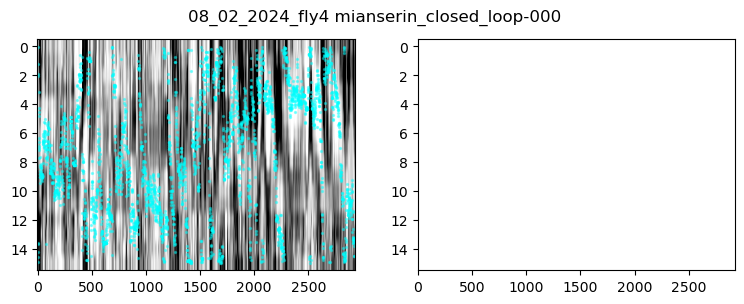

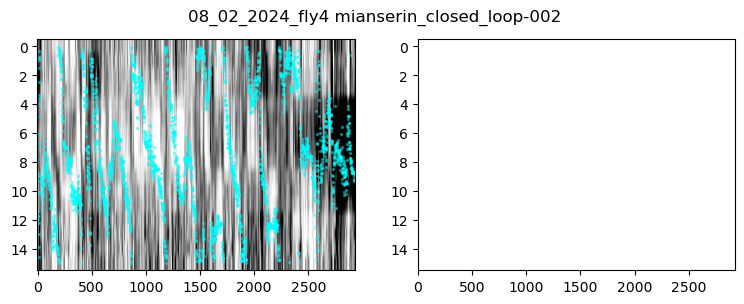

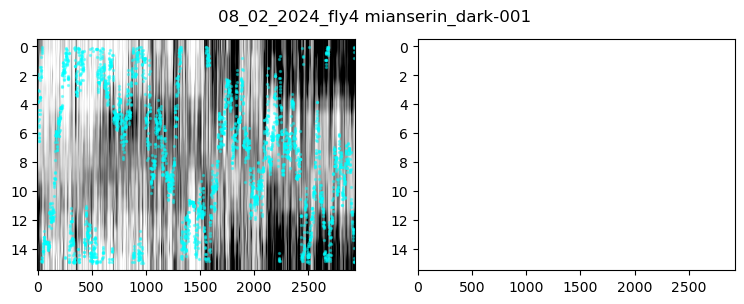

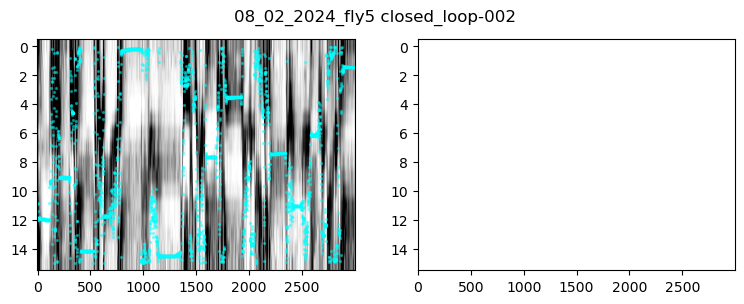

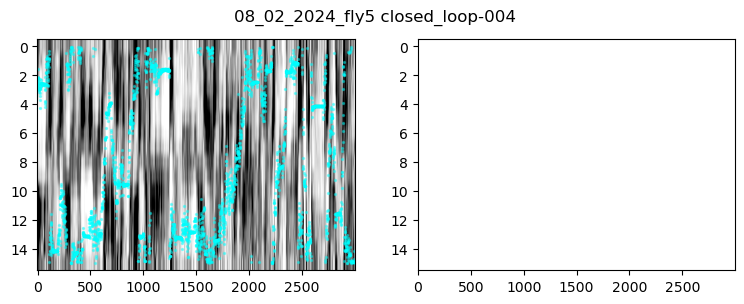

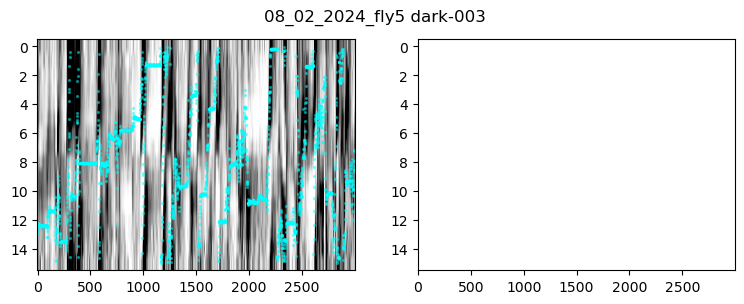

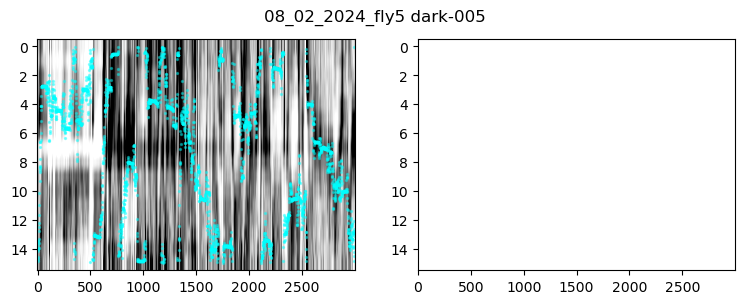

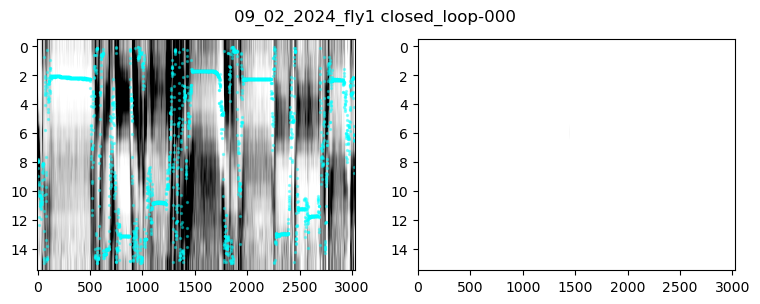

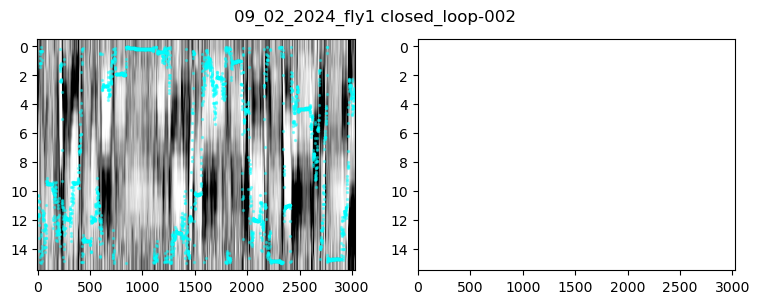

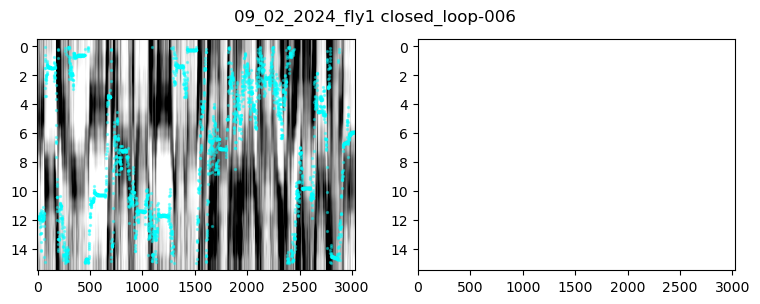

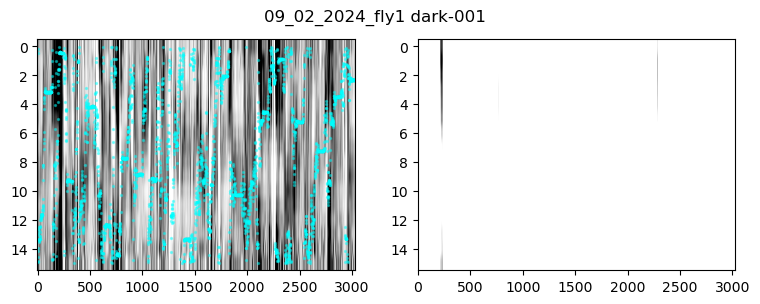

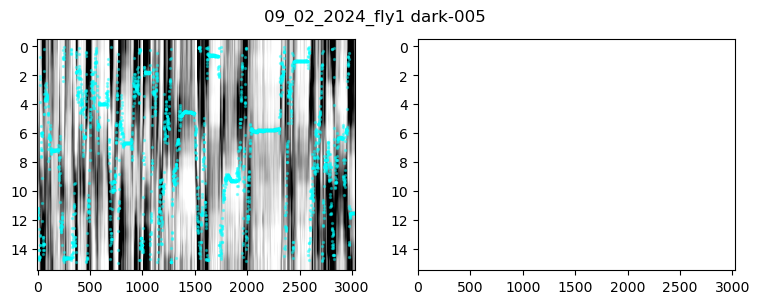

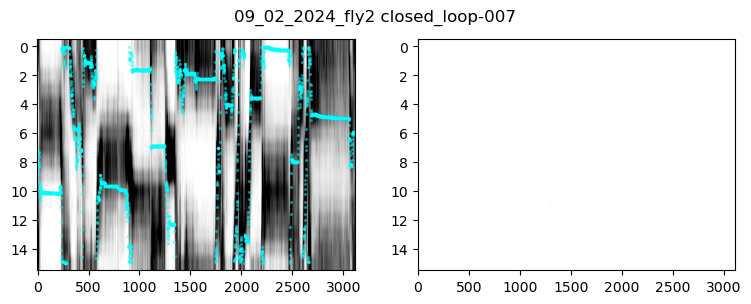

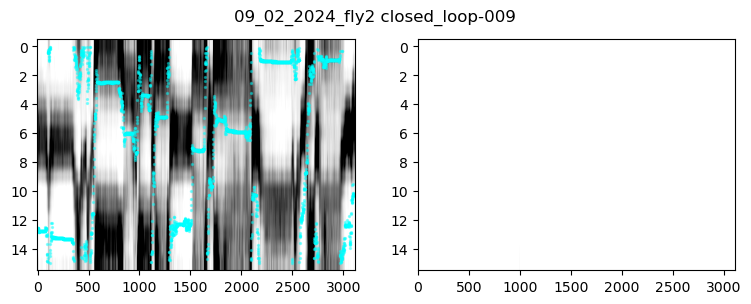

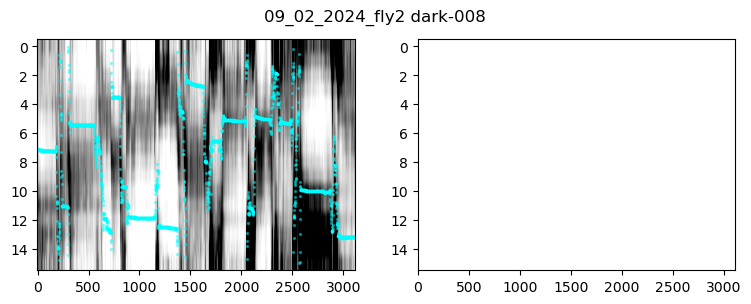

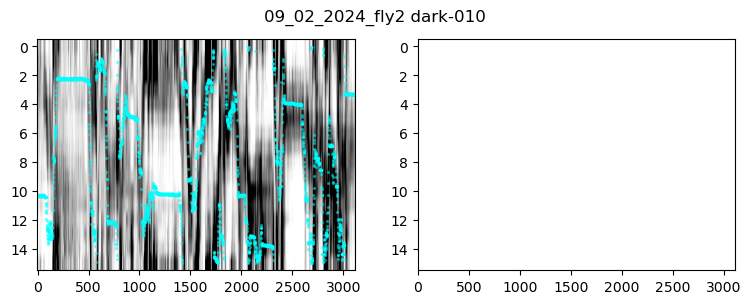

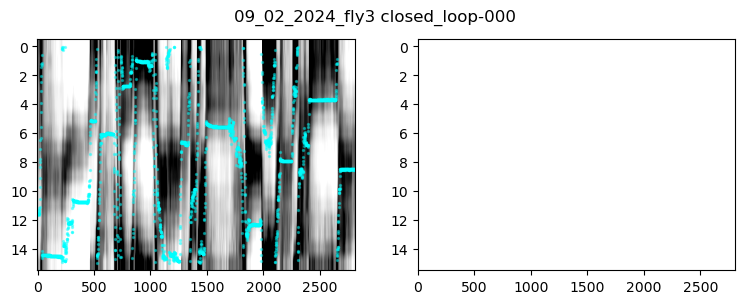

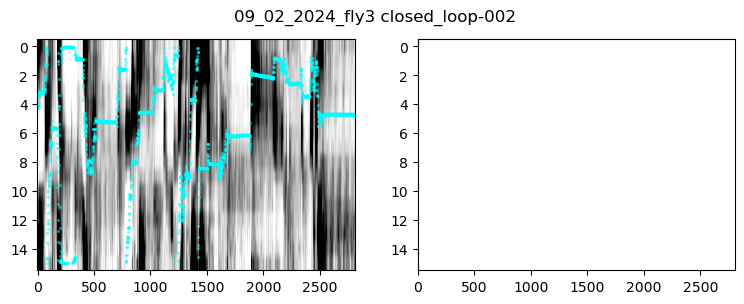

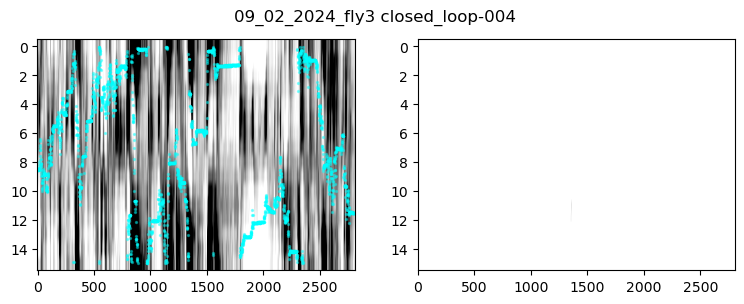

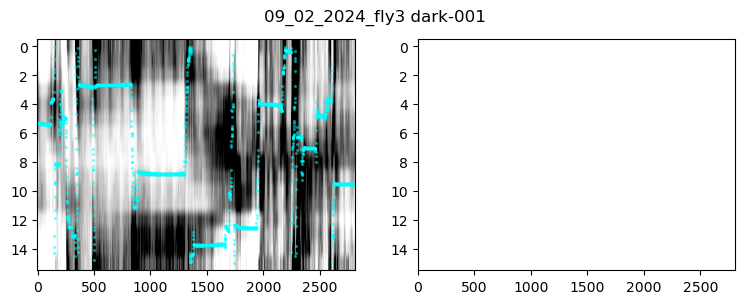

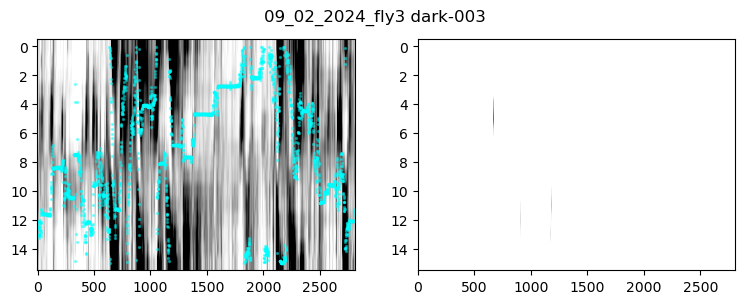

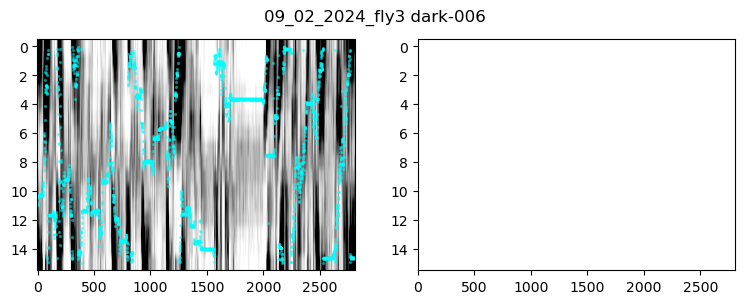

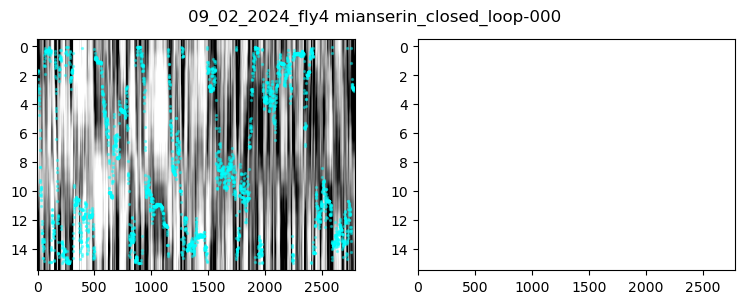

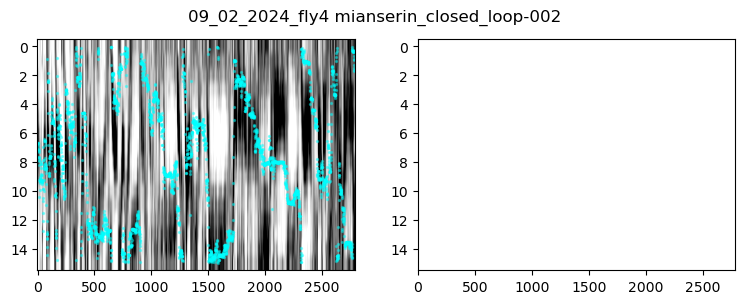

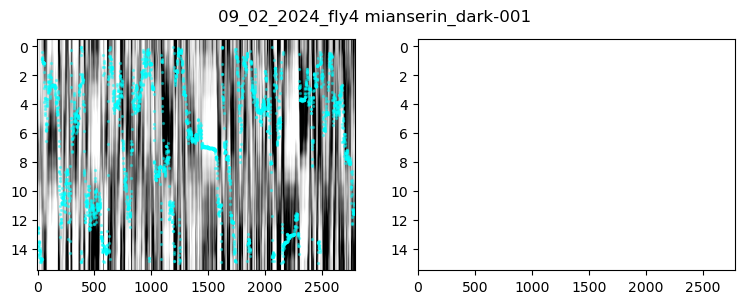

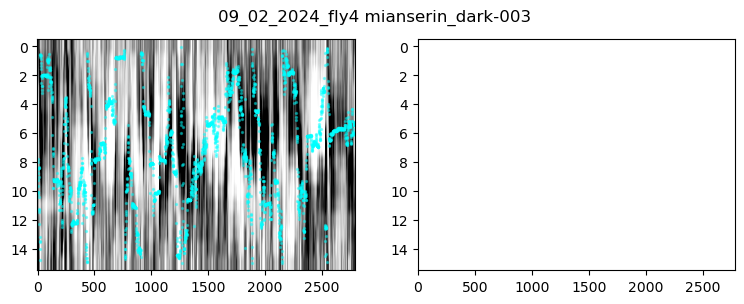

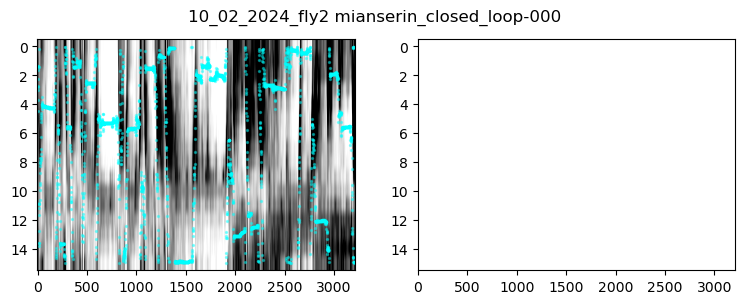

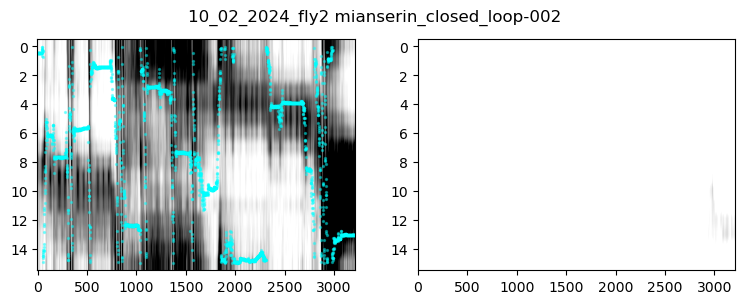

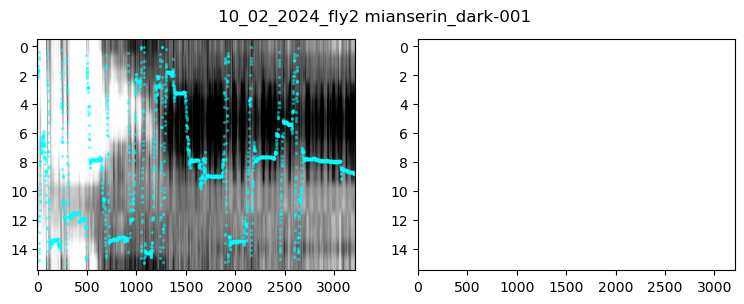

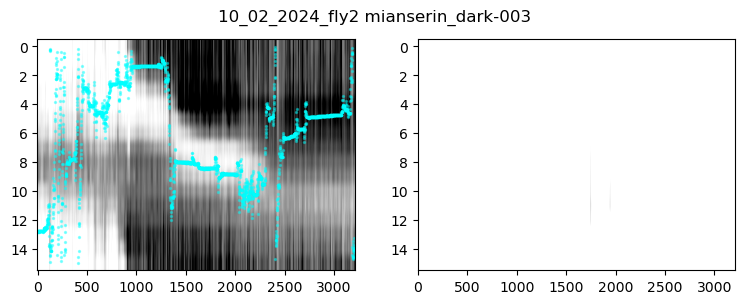

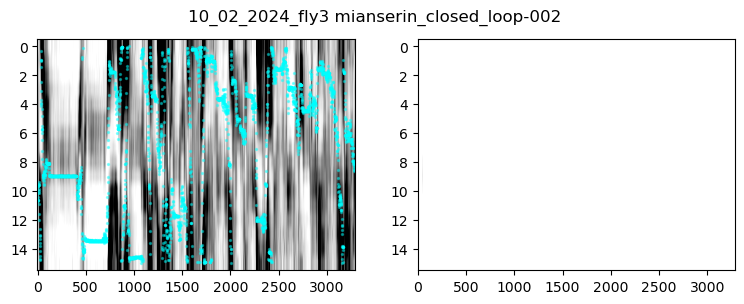

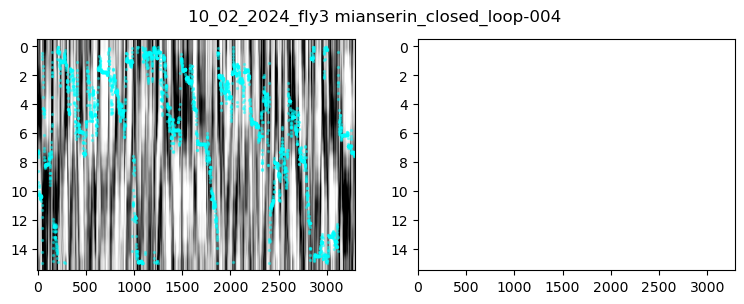

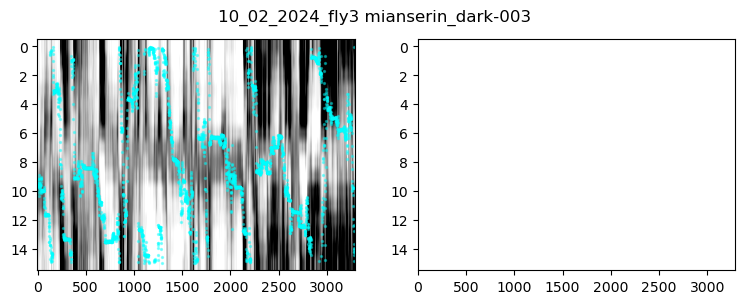

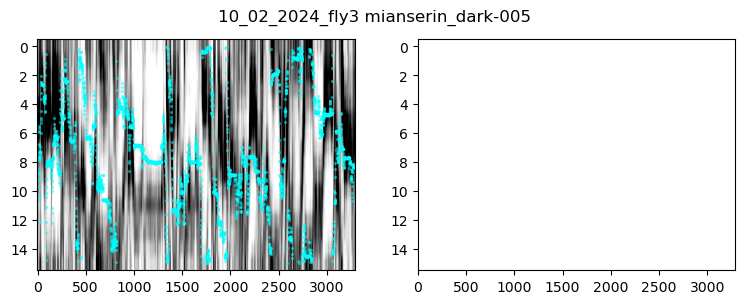

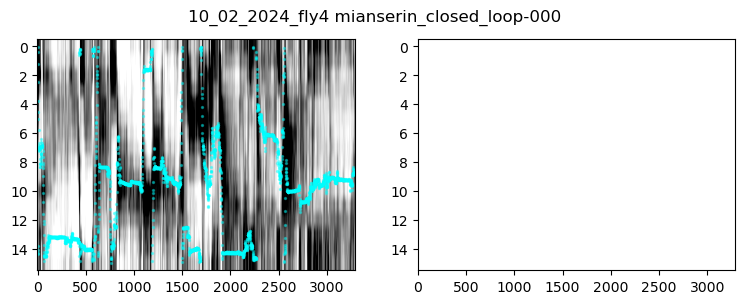

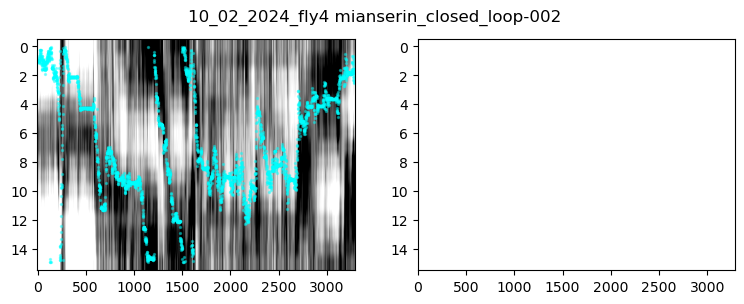

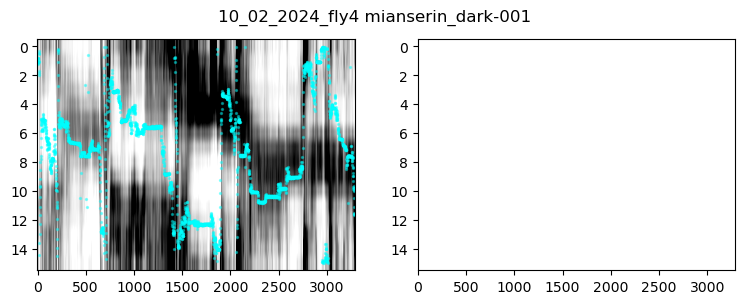

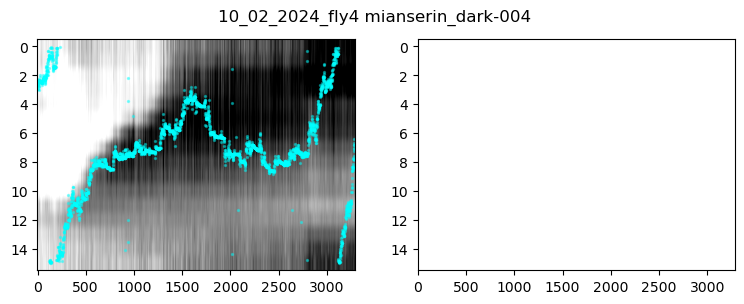

In [108]:
for i, (_, row) in enumerate(sess_df.iterrows()):
    outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    ts = get_ts(pp,coef=0)
    bins = np.arange(16)
    
    # print(pp.voltage_recording_aligned['Time(ms)'])
    dt = pp.metadata['frame_period']*pp.metadata['layout']['frames_per_sequence']
    
    fig, ax=plt.subplots(1,2, figsize=[9,3])
    ax[0].imshow(ts['y_epg'][0,:,:],aspect='auto',cmap='Greys', 
                 vmin=np.percentile(ts['y_epg'][0,:,:],10), 
                 vmax=np.percentile(ts['y_epg'][0,:,:],90))
    _heading = 15*(ts['heading']+np.pi)/2/np.pi
    x = np.arange(_heading.shape[0])
    ax[0].scatter(x,_heading, color='cyan', s=2, alpha=.4)
    
    heading_bins, y_h_aligned, y_h_aligned_z = align_to_heading(ts)
    ax[1].imshow(y_h_aligned[1,:,:], aspect='auto',cmap='Greys', 
                 vmin=np.percentile(ts['y_epg'][0,:,:],10), 
                 vmax=np.percentile(ts['y_epg'][0,:,:],90))
    
    # ax[1].hist(ts['offset_epg'],bins = np.linspace(-np.pi,np.pi, num=17), density=True)
    fig.suptitle(f"{row['fly_id']} {row['sess']}")
    
#     add shifted data and histogram